<a href="https://colab.research.google.com/github/rullr/recommendation-system/blob/main/final_project_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data from Kaggle**

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"msyahrulromadhon","key":"2b392b6b38816be7e676281afc08c491"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download arashnic/book-recommendation-dataset

 88% 21.0M/23.8M [00:00<00:00, 112MB/s] 
100% 23.8M/23.8M [00:00<00:00, 116MB/s]


In [ ]:
!mkdir data

In [ ]:
!unzip /content/book-recommendation-dataset.zip -d data/

Archive:  /content/book-recommendation-dataset.zip
  inflating: data/Books.csv          
  inflating: data/Ratings.csv        
  inflating: data/Users.csv          
  inflating: data/recsys_taxonomy2.png  


# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

# **Data Loading**

In [ ]:
books = pd.read_csv('/content/data/Books.csv', low_memory=False)
ratings = pd.read_csv('/content/data/Ratings.csv')
users = pd.read_csv('/content/data/Users.csv')

In [ ]:
# Data lima baris teratas pada books
books = books.iloc[:100000]
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
# Data lima baris teratas pada ratings
ratings = ratings.iloc[:100000]
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# Data lima baris teratas pada users
users = users.iloc[:100000]
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# **Exploratory Data Analysis**

## **Books**

In [ ]:
# Ukuran tabel pada data books
books.shape

(100000, 8)

In [ ]:
# Informasi pada data books
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 100000 non-null  object
 1   Book-Title           100000 non-null  object
 2   Book-Author          100000 non-null  object
 3   Year-Of-Publication  100000 non-null  object
 4   Publisher            100000 non-null  object
 5   Image-URL-S          100000 non-null  object
 6   Image-URL-M          100000 non-null  object
 7   Image-URL-L          100000 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
print('Jumlah author: ', len(books['Book-Author'].unique()))
print('Book author: ', books['Book-Author'].unique())

Jumlah author:  41997
Book author:  ['Mark P. O. Morford' 'Richard Bruce Wright' "Carlo D'Este" ...
 'Maurizio Maggiani' 'Rachel Vincer' 'Laura Martin']


## **Ratings**

In [ ]:
# Ukuran tabel pada data ratings
ratings.shape

(100000, 3)

In [ ]:
# Informasi pada data ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      100000 non-null  int64 
 1   ISBN         100000 non-null  object
 2   Book-Rating  100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [ ]:
# Mengubah tipe data kolom User-ID menjadi object
ratings['User-ID'] = ratings['User-ID'].astype(object)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      100000 non-null  object
 1   ISBN         100000 non-null  object
 2   Book-Rating  100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
ratings.describe().round(2)

,Book-Rating
count,100000.00
mean,3.19
std,3.91
min,0.00
25%,0.00
50%,0.00
75%,7.00
max,10.00


In [ ]:
ratings['Book-Rating'].value_counts()

0     57521
8     10399
7      8103
10     7039
9      6109
5      4518
6      4003
4       999
3       710
2       321
1       278
Name: Book-Rating, dtype: int64

In [ ]:
ratings.loc[(ratings['Book-Rating']==0)]

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
2,276727,0446520802,0
5,276733,2080674722,0
10,276746,0425115801,0
11,276746,0449006522,0
...,...,...,...
99995,23288,0802448089,0
99996,23288,0802448151,0
99997,23288,0802448267,0
99998,23288,0802457010,0


In [ ]:
# Drop baris dengan nilai 'Book-Rating' = 0
ratings = ratings.loc[(ratings[['Book-Rating']]!=0).all(axis=1)]
ratings.shape

(42479, 3)

<Axes: title={'center': 'Distribusi Nilai Rating Buku'}, xlabel='Book-Rating', ylabel='count'>

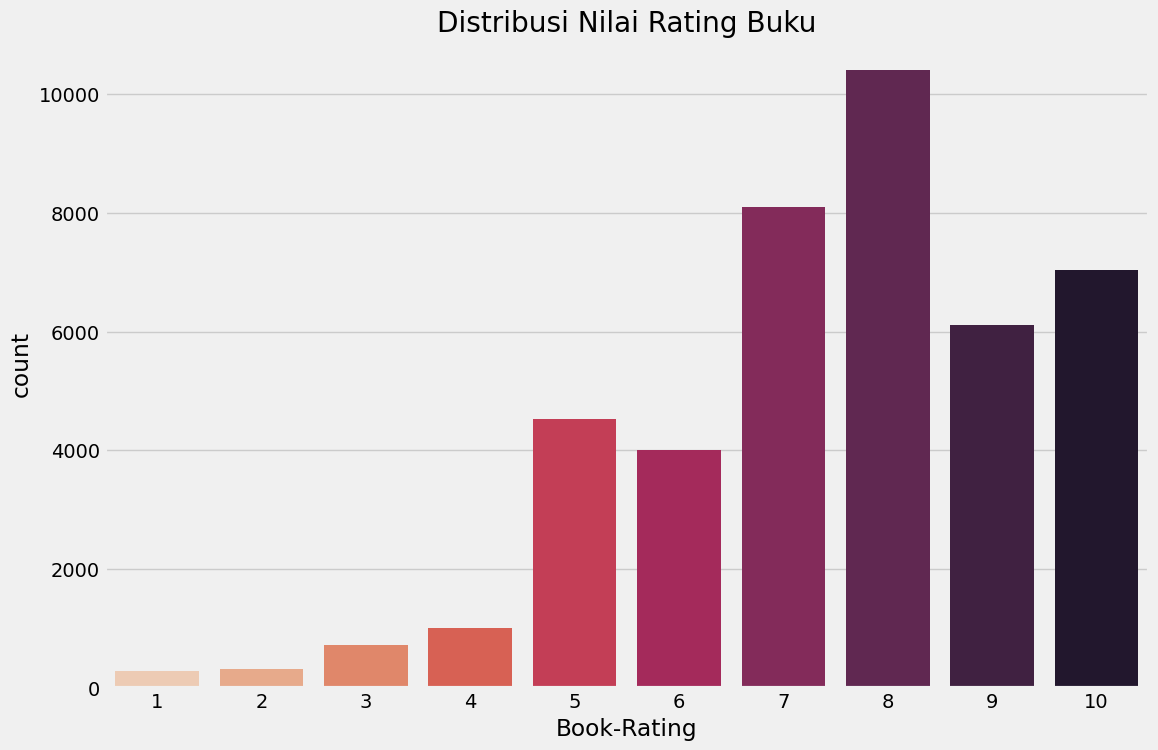

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
plt.title('Distribusi Nilai Rating Buku')
sns.countplot(data=ratings , x='Book-Rating', palette='rocket_r')

## **Users**

In [ ]:
# Ukuran tabel pada data users
users.shape

(100000, 3)

In [ ]:
# Informasi pada data users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   100000 non-null  int64  
 1   Location  100000 non-null  object 
 2   Age       60269 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
users['User-ID'] = users['User-ID'].astype(object)
users['Age'].fillna(0, inplace=True)
users['Age'] = users['Age'].astype(int)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User-ID   100000 non-null  object
 1   Location  100000 non-null  object
 2   Age       100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


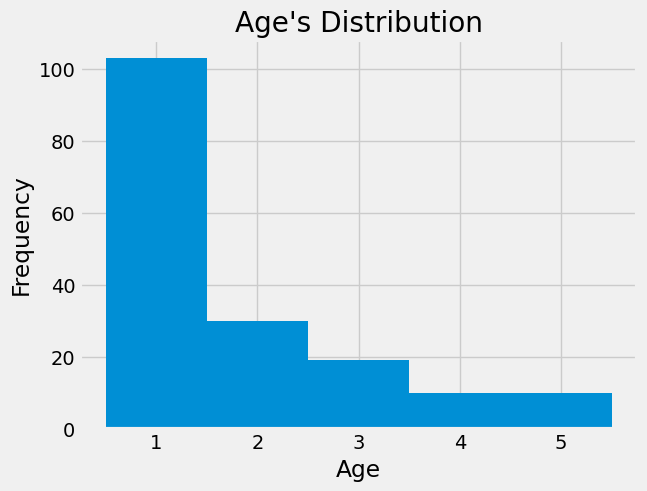

In [ ]:
plt.hist(users['Age'], bins=range(1,7), align='left')
plt.title("Age's Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(range(1,6))
plt.show()

# **Data Preparation**

## **Handling Missing Value**

In [ ]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [ ]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
users.isnull().sum()

User-ID     0
Location    0
Age         0
dtype: int64

## **Merging Books and Ratings**

In [ ]:
books_df = books.merge(ratings, on='ISBN')
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,2954,8
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,11676,9
4,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,11676,8


In [ ]:
print('Jumlah user: ', len(books_df['User-ID'].unique()))
print('Jumlah buku: ', len(books_df['Book-Title'].unique()))
print('Jumlah data rating: ', len(books_df['Book-Rating']))

Jumlah user:  5884
Jumlah buku:  21092
Jumlah data rating:  33335


In [ ]:
# Menyamakan jenis item berdasarkan item_id
fix_books = books_df.sort_values('ISBN', ascending=True)
fix_books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
16736,0001047973,Brave New World,Aldous Huxley,1999,Trafalgar Square Publishing,http://images.amazon.com/images/P/0001047973.0...,http://images.amazon.com/images/P/0001047973.0...,http://images.amazon.com/images/P/0001047973.0...,11944,9
15308,0001360469,Babe Dressing,Mandy Stanley,1997,HarperCollins Publishers,http://images.amazon.com/images/P/0001360469.0...,http://images.amazon.com/images/P/0001360469.0...,http://images.amazon.com/images/P/0001360469.0...,10067,10
15311,0001374869,Baby Plays (Collins Baby and Toddler Series),Fiona Pragoff,1994,HarperCollins Publishers,http://images.amazon.com/images/P/0001374869.0...,http://images.amazon.com/images/P/0001374869.0...,http://images.amazon.com/images/P/0001374869.0...,10067,10
25012,0001939203,The Collins Book of Nursery Tales,Jonathan Langley,1993,HarperCollins Publishers,http://images.amazon.com/images/P/0001939203.0...,http://images.amazon.com/images/P/0001939203.0...,http://images.amazon.com/images/P/0001939203.0...,14867,8
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
...,...,...,...,...,...,...,...,...,...,...
15334,B0000633PU,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole,0,Renaissance eBooks,http://images.amazon.com/images/P/B0000633PU.0...,http://images.amazon.com/images/P/B0000633PU.0...,http://images.amazon.com/images/P/B0000633PU.0...,10118,8
25539,B00006CRTE,"Devil Knows You're Dead, The: A Matthew Scudde...",Lawrence Block,0,PerfectBound,http://images.amazon.com/images/P/B00006CRTE.0...,http://images.amazon.com/images/P/B00006CRTE.0...,http://images.amazon.com/images/P/B00006CRTE.0...,15418,9
26604,B00007MF56,"More, Now, Again: A Memoir of Addiction",Elizabeth Wurtzel,2001,Simon &amp; Schuster,http://images.amazon.com/images/P/B00007MF56.0...,http://images.amazon.com/images/P/B00007MF56.0...,http://images.amazon.com/images/P/B00007MF56.0...,16718,9
14523,B0000A2U93,Carmilla,Joseph Sheridan Le Fanu,0,Soft Editions Ltd,http://images.amazon.com/images/P/B0000A2U93.0...,http://images.amazon.com/images/P/B0000A2U93.0...,http://images.amazon.com/images/P/B0000A2U93.0...,9029,7


In [ ]:
import re

fix_books.drop(columns=["Year-Of-Publication", "Publisher", "Image-URL-S", "Image-URL-M", "Image-URL-L"],axis=1,inplace=True)
fix_books["Book-Title"]=fix_books["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
fix_books.head()

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating
16736,0001047973,Brave New World,Aldous Huxley,11944,9
15308,0001360469,Babe Dressing,Mandy Stanley,10067,10
15311,0001374869,Baby Plays Collins Baby and Toddler Series,Fiona Pragoff,10067,10
25012,0001939203,The Collins Book of Nursery Tales,Jonathan Langley,14867,8
0,0002005018,Clara Callan,Richard Bruce Wright,8,5


In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = fix_books.drop_duplicates('ISBN')
preparation.head()

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating
16736,0001047973,Brave New World,Aldous Huxley,11944,9
15308,0001360469,Babe Dressing,Mandy Stanley,10067,10
15311,0001374869,Baby Plays Collins Baby and Toddler Series,Fiona Pragoff,10067,10
25012,0001939203,The Collins Book of Nursery Tales,Jonathan Langley,14867,8
0,0002005018,Clara Callan,Richard Bruce Wright,8,5


In [ ]:
# Mengonversi data series ISBN menjadi bentuk list
id = preparation['ISBN'].tolist()

# Mengonversi data series Book-Title menjadi bentuk list
book_name = preparation['Book-Title'].tolist()

# Mengonversi data series Book-Author menjadi bentuk list
author_name = preparation['Book-Author'].tolist()

print(len(id))
print(len(book_name))
print(len(author_name))

22607
22607
22607


In [ ]:
# Membuat dictionary untuk data ISBN, Book-Title, dan Book-Author
books_new = pd.DataFrame({
    'id': id,
    'book_title': book_name,
    'author_name': author_name
})
books_new

,id,book_title,author_name
0,0001047973,Brave New World,Aldous Huxley
1,0001360469,Babe Dressing,Mandy Stanley
2,0001374869,Baby Plays Collins Baby and Toddler Series,Fiona Pragoff
3,0001939203,The Collins Book of Nursery Tales,Jonathan Langley
4,0002005018,Clara Callan,Richard Bruce Wright
...,...,...,...
22602,B0000633PU,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole
22603,B00006CRTE,Devil Knows You re Dead The A Matthew Scudder ...,Lawrence Block
22604,B00007MF56,More Now Again A Memoir of Addiction,Elizabeth Wurtzel
22605,B0000A2U93,Carmilla,Joseph Sheridan Le Fanu


# **Model Development**

## **Content Based Filtering**

In [ ]:
books_data = books_new
books_data.sample(5)

,id,book_title,author_name
14466,0688180639,Vinegar Hill Oprah s Book Club Hardcover,A. Manette Ansay
5233,0375709150,Driving over Lemons An Optimist in Spain Vinta...,Chris Stewart
9880,0451527569,The House of Mirth Signet Classics Paperback,Edith Wharton
17359,0871318156,Dr Atkins New Carbohydrate Gram Counter,Robert C. Atkins
8761,0446610496,The Diary of V The Affair Diary of V,Debra Kent


### **TF-IDF Vectorizer**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data author_name
tf.fit(books_data['author_name'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['aa', 'aaron', 'aarsen', ..., 'â¼scher', 'â¼skind', 'â¼ter'],
      dtype=object)

Selanjutnya, lakukan fit dan transformasi ke dalam bentuk matriks.

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(books_data['author_name'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(22607, 9488)

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Selanjutnya, mari kita lihat matriks tf-idf untuk beberapa Judul buku dan Pengarang buku.

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan pengarang buku
# Baris diisi dengan judul buku

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=books_data.book_title
).sample(22, axis=1).sample(10, axis=0)

,brendtro,capucilli,aldrin,whitecap,walt,mirvis,mclaim,orion,maryann,ashleigh,...,rosenbaum,dickson,benard,singular,shinn,keith,heat,hampson,wilds,parkhurst
book_title,,,,,,,,,,,,,,,,,,,,,
Maggie Needs an Alibi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Why Things Burn Poems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agents of Chaos I Hero s Trial Star Wars The New Jedi Order Book 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tai Pan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lives of the Monster Dogs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quilted for Christmas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hate Is My Neighbor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Stephen King s Danse Macabre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hiding Place Women Who Dare Harlequin Superromance No 693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Cosine Similarity**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim
cosine_sim_df = pd.DataFrame(cosine_sim, index=books_data['book_title'], columns=books_data['book_title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap itemm
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (22607, 22607)


book_title,Bitch In Praise of Difficult Women,Are You There God It s Me Margaret,Going for Great Ag Fiction American Girl,This Place Has No Atmosphere,The Big Book for Peace
book_title,,,,,
Tipping the Velvet,0.000000,0.0,0.0,0.0,0.0
The Phantom of the Opera Puffin Classics,0.000000,0.0,0.0,0.0,0.0
Wrongful Death,0.000000,0.0,0.0,0.0,0.0
The First Eagle,0.000000,0.0,0.0,0.0,0.0
A Room of One s Own,0.000000,0.0,0.0,0.0,0.0
Breathing Room Avon Romance,0.269065,0.0,0.0,0.0,0.0
How Not to Be a Perfect Mother The Crafty Mother s Guide to a Quiet Life How Not to,0.000000,0.0,0.0,0.0,0.0
Someone s Watching,0.000000,0.0,0.0,0.0,0.0
Family Life Birth Death and the Whole Damn Thing Corgi Book,0.256890,0.0,0.0,0.0,0.0


### **Getting a Recommendation**

In [ ]:
def book_recommendations(book_title, similarity_data=cosine_sim_df, items=books_data[['book_title', 'author_name']], k=5):
    index = similarity_data.loc[:,book_title].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(book_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
books_data[books_data['book_title'].eq('Tipping the Velvet')]

,id,book_title,author_name
19365,1573227889,Tipping the Velvet,Sarah Waters


In [ ]:
# Mendapatkan rekomendasi buku yang mirip
book_recommendations('Tipping the Velvet')

,book_title,author_name
0,Fingersmith,Sarah Waters
1,Fingersmith,Sarah Waters
2,Fingersmith,Sarah Waters
3,Fingersmith,Sarah Waters
4,Affinity,Sarah Waters


# **Collaborative Filtering**

## **Data Understanding**

In [ ]:
df = ratings
df

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
99973,23288,0721410545,8
99974,23288,0721411134,10
99981,23288,0766602516,8
99985,23288,0770427502,7


## **Data Preparation**

Pada tahap ini, dilakukan persiapan data untuk menyandikan (encode) fitur **User-ID** dan **ISBN** ke dalam indeks integer.

In [ ]:
# Mengubah User-ID menjadi list tanpa nilai yang sama
user_ids = df['User-ID'].unique().tolist()
print('list User-ID: ', user_ids)

# Melakukan encoding User-ID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User-ID: ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke User-ID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke User-ID: ', user_encoded_to_user)

# Mengubah ISBN menjadi list tanpa nilai yang sama
book_ids = df['ISBN'].unique().tolist()

# Melakukan proses encoding ISBN
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}

# Melakukan proses encoding angka ke ISBN
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

list User-ID:  [276726, 276729, 276736, 276737, 276744, 276745, 276747, 276748, 276751, 276754, 276755, 276760, 276762, 276768, 276772, 276774, 276780, 276786, 276788, 276796, 276798, 276800, 276804, 276808, 276811, 276812, 276813, 276814, 276820, 276822, 276827, 276828, 276830, 276832, 276835, 276837, 276842, 276847, 276848, 276850, 276853, 276854, 276857, 276859, 276861, 276862, 276863, 276866, 276870, 276872, 276873, 276875, 276878, 276879, 276884, 276887, 276888, 276896, 276904, 276905, 276911, 276912, 276915, 276916, 276925, 276927, 276928, 276929, 276934, 276936, 276939, 276949, 276953, 276954, 276957, 276959, 276964, 276965, 276984, 276986, 276988, 276990, 276992, 276994, 276998, 277002, 277007, 277009, 277010, 277012, 277018, 277023, 277028, 277031, 277032, 277036, 277042, 277048, 277051, 277052, 277053, 277056, 277058, 277065, 277072, 277074, 277079, 277085, 277087, 277090, 277094, 277096, 277107, 277109, 277116, 277124, 277128, 277129, 277134, 277135, 277139, 277143, 277157, 

Berikutnya, petakan User-ID dan ISBN ke dataframe yang berkaitan.

In [ ]:
# Mapping User-ID ke dataframe user
df['user'] = df['User-ID'].map(user_to_user_encoded)

# Mapping ISBN ke dataframe book
df['book'] = df['ISBN'].map(book_to_book_encoded)

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah buku
num_book = len(book_encoded_to_book)
print(num_book)

# Mengubah rating menjadi nilai float
df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['Book-Rating'])

# Nilai maksimal rating
max_rating = max(df['Book-Rating'])

print('Number of User: {}, Number of Book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

6953
31207
Number of User: 6953, Number of Book: 31207, Min Rating: 1.0, Max Rating: 10.0


## **Splitting Data for Training and Validation**

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,User-ID,ISBN,Book-Rating,user,book
94055,21014,0671776134,9.0,6300,3705
76317,16601,0671019554,9.0,5119,25796
1335,277315,0060173289,8.0,172,616
28834,6575,0836218515,9.0,2423,764
68658,14387,0679735739,8.0,4514,21927
...,...,...,...,...,...
17469,3167,0453010105,5.0,1500,5630
27984,6563,059035342X,8.0,2418,1567
89045,19664,1563055597,8.0,5927,28875
2039,277478,0312979533,7.0,215,846


In [ ]:
# Membuat variabel x untuk mencocokkan data user dan buku menjadi satu value
x = df[['user', 'book']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 90% data train dan 10% data validasi
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 6300  3705]
 [ 5119 25796]
 [  172   616]
 ...
 [ 5927 28875]
 [  215   846]
 [ 3206 12982]] [0.88888889 0.88888889 0.77777778 ... 0.77777778 0.66666667 0.77777778]


# **Proses Training**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.book_embedding = layers.Embedding(
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_book, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    book_vector = self.book_embedding(inputs[:, 1])
    book_bias = self.book_bias(inputs[:, 1])

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x)

In [ ]:
model = RecommenderNet(num_users, num_book, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10
1195/1195 [==============================] - 54s 42ms/step - loss: 0.6575 - mean_squared_error: 0.0751 - val_loss: 0.6146 - val_mean_squared_error: 0.0524
Epoch 2/10
1195/1195 [==============================] - 44s 37ms/step - loss: 0.5890 - mean_squared_error: 0.0419 - val_loss: 0.6343 - val_mean_squared_error: 0.0618
Epoch 3/10
1195/1195 [==============================] - 37s 31ms/step - loss: 0.5793 - mean_squared_error: 0.0382 - val_loss: 0.6382 - val_mean_squared_error: 0.0636
Epoch 4/10
1195/1195 [==============================] - 40s 33ms/step - loss: 0.5757 - mean_squared_error: 0.0367 - val_loss: 0.6382 - val_mean_squared_error: 0.0635
Epoch 5/10
1195/1195 [==============================] - 39s 33ms/step - loss: 0.5730 - mean_squared_error: 0.0354 - val_loss: 0.6393 - val_mean_squared_error: 0.0640
Epoch 6/10
1195/1195 [==============================] - 38s 32ms/step - loss: 0.5717 - mean_squared_error: 0.0348 - val_loss: 0.6389 - val_mean_squared_error: 0.0637
Epoc

## **Metrik Evaluasi**

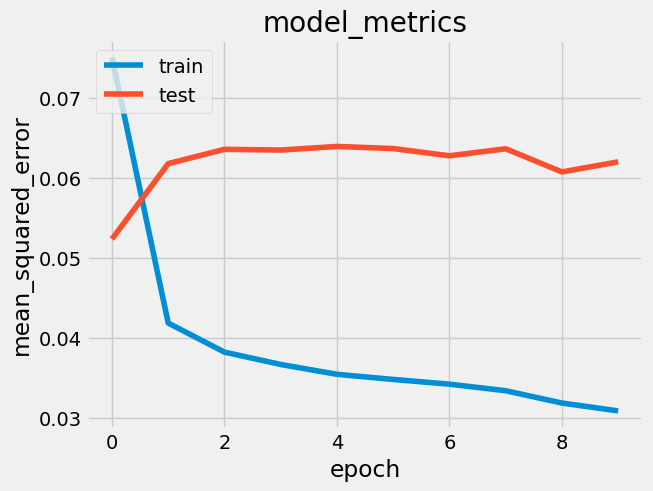

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Getting Book Recommendation**

In [ ]:
book_df = books_new
df = ratings

# Mengambil sample user
user_id = df['User-ID'].sample(1).iloc[0]
book_buyed_by_user = df[df['User-ID'] == user_id]

book_not_buyed = book_df[~book_df['id'].isin(book_buyed_by_user['ISBN'].values)]['id']
book_not_buyed = list(
    set(book_not_buyed)
    .intersection(set(book_to_book_encoded.keys()))
)

book_not_buyed = [[book_to_book_encoded.get(x)] for x in book_not_buyed]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_buyed), book_not_buyed)
)
print(user_book_array)

[[ 3785  9758]
 [ 3785 30674]
 [ 3785 30683]
 ...
 [ 3785 29961]
 [ 3785 26586]
 [ 3785 25920]]


In [ ]:
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(book_not_buyed[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Book with high ratings from user')
print('----' * 8)

top_book_user = (
    book_buyed_by_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

book_df_rows = book_df[book_df['id'].isin(top_book_user)]
for row in book_df_rows.itertuples():
    print(row.book_title, ':', row.author_name)

print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)

recommended_book = book_df[book_df['id'].isin(recommended_book_ids)]
for row in recommended_book.itertuples():
    print(row.book_title, ':', row.author_name)

554/554 [==============================] - 1s 2ms/step
Showing recommendations for users: 11676
Book with high ratings from user
--------------------------------
Lover Beware : Christine Feehan
Franklin s Neighborhood Franklin : Paulette Bourgeois
Sisterchicks on the Loose Sisterchicks : Robin Jones Gunn
--------------------------------
Top 10 book recommendation
--------------------------------
From Dawn to Decadence 1500 to the Present 500 Years of Western Cultural Life : Jacques Barzun
Falling Up : Shel Silverstein
The BFG : Roald Dahl
Asterix at the Olympic Games : Rene De Goscinny
The Two Towers The Lord of the Rings Part 2 : J.R.R. TOLKIEN
Cry No More Howard Linda : LINDA HOWARD
It s Always Something : Gilda Radner
Christine : Stephen King
Body of Evidence : Patricia Cornwell
Shambhala Sacred Path of the Warrior : CHOGYAM TRUNGPA
